# Clustering to find States

In [67]:
# General
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and machine learning
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.linear_model import Lasso, ElasticNet, RidgeClassifier, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.feature_selection import SequentialFeatureSelector
import scipy.cluster.hierarchy as shc 
from sklearn.decomposition import PCA 



# Visualization
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score

from sklearn.mixture import GaussianMixture

%matplotlib inline
sns.set_style("whitegrid")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [68]:
# load data 
data = pd.read_csv('data_cleaned.csv')
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Customer Zipcode,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Price,Product Status,Shipping Mode,Late Days,order_year,order_month,order_day,shipping_year,shipping_month,shipping_day,order_to_ship,total_lead_time_real,total_lead_time_scheduled
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,Sporting Goods,Caguas,Puerto Rico,Consumer,PR,725.0,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,13.110000,0.04,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,327.75,0,Standard Class,-1,2018,1,31,2018,2,3,3,6,7
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,Sporting Goods,Caguas,Puerto Rico,Consumer,PR,725.0,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,16.389999,0.05,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,327.75,0,Standard Class,1,2018,1,13,2018,1,18,5,10,9
2,CASH,4,4,-247.779999,309.720001,Shipping on time,Sporting Goods,San Jose,EE. UU.,Consumer,CA,95125.0,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,18.030001,0.06,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,327.75,0,Standard Class,0,2018,1,13,2018,1,17,4,8,8
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,Sporting Goods,Los Angeles,EE. UU.,Home Office,CA,90027.0,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,22.940001,0.07,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,327.75,0,Standard Class,-1,2018,1,13,2018,1,16,3,6,7
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,Sporting Goods,Caguas,Puerto Rico,Corporate,PR,725.0,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,29.500000,0.09,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,327.75,0,Standard Class,-2,2018,1,13,2018,1,15,2,4,6


In [69]:
# columns with only one unique value
data.columns[data.nunique() == 1]
data.drop(columns=['Product Status'], inplace=True)

In [70]:
# Unique entries per column
data.nunique()

Type                                 4
Days for shipping (real)             7
Days for shipment (scheduled)        4
Benefit per order                21998
Sales per customer                2927
Delivery Status                      4
Category Name                       50
Customer City                      562
Customer Country                     2
Customer Segment                     3
Customer State                      44
Customer Zipcode                   995
Department Name                     11
Latitude                         11248
Longitude                         4485
Market                               5
Order City                        3597
Order Country                      164
Order Item Discount               1017
Order Item Discount Rate            18
Order Item Product Price            75
Order Item Profit Ratio            162
Order Item Quantity                  5
Sales                              193
Order Item Total                  2927
Order Profit Per Order   

In [71]:
data['Order Status'].value_counts()

Order Status
COMPLETE           59489
PENDING_PAYMENT    39831
PROCESSING         21902
PENDING            20227
CLOSED             19616
ON_HOLD             9804
SUSPECTED_FRAUD     4062
CANCELED            3692
PAYMENT_REVIEW      1893
Name: count, dtype: int64

In [72]:
data['Delivery Status'].value_counts()

Delivery Status
Late delivery        98976
Advance shipping     41592
Shipping on time     32194
Shipping canceled     7754
Name: count, dtype: int64

In [73]:
data = data[data['Order Status'] == 'COMPLETE']
data

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Customer Zipcode,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Product Price,Shipping Mode,Late Days,order_year,order_month,order_day,shipping_year,shipping_month,shipping_day,order_to_ship,total_lead_time_real,total_lead_time_scheduled
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,Sporting Goods,Caguas,Puerto Rico,Consumer,PR,725.0,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,13.110000,0.04,327.750000,0.29,1,327.750000,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,327.750000,Standard Class,-1,2018,1,31,2018,2,3,3,6,7
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,Sporting Goods,Los Angeles,EE. UU.,Home Office,CA,90027.0,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,22.940001,0.07,327.750000,0.08,1,327.750000,304.809998,22.860001,Oceania,Queensland,COMPLETE,327.750000,Standard Class,-1,2018,1,13,2018,1,16,3,6,7
6,DEBIT,2,1,95.180000,288.420013,Late delivery,Sporting Goods,Caguas,Puerto Rico,Home Office,PR,725.0,Fitness,18.242538,-66.037056,Pacific Asia,Guangzhou,China,39.330002,0.12,327.750000,0.33,1,327.750000,288.420013,95.180000,Eastern Asia,Guangdong,COMPLETE,327.750000,First Class,1,2018,1,13,2018,1,15,2,4,3
13,DEBIT,2,1,24.580000,245.809998,Late delivery,Sporting Goods,Caguas,Puerto Rico,Corporate,PR,725.0,Fitness,18.278439,-66.037056,Pacific Asia,Sangli,India,81.940002,0.25,327.750000,0.10,1,327.750000,245.809998,24.580000,South Asia,Maharashtra,COMPLETE,327.750000,First Class,1,2018,1,13,2018,1,15,2,4,3
15,DEBIT,2,1,-259.579987,324.470001,Late delivery,Sporting Goods,Caguas,Puerto Rico,Corporate,PR,725.0,Fitness,18.284050,-66.037056,Pacific Asia,Sangli,India,3.280000,0.01,327.750000,-0.80,1,327.750000,324.470001,-259.579987,South Asia,Maharashtra,COMPLETE,327.750000,First Class,1,2018,1,13,2018,1,15,2,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180497,DEBIT,3,4,138.229996,383.980011,Advance shipping,Fishing,Saint Paul,EE. UU.,Consumer,MN,55112.0,Fan Shop,36.153011,-119.336479,Pacific Asia,Rockhampton,Australia,16.000000,0.04,399.980011,0.36,1,399.980011,383.980011,138.229996,Oceania,Queensland,COMPLETE,399.980011,Standard Class,-1,2016,1,16,2016,1,19,3,6,7
180502,DEBIT,2,4,112.669998,359.980011,Advance shipping,Fishing,Highland,EE. UU.,Corporate,CA,92346.0,Fan Shop,34.135822,-117.220947,Pacific Asia,Qingdao,China,40.000000,0.10,399.980011,0.31,1,399.980011,359.980011,112.669998,Eastern Asia,Shandong,COMPLETE,399.980011,Standard Class,-2,2016,1,16,2016,1,18,2,4,6
180505,DEBIT,4,2,85.000000,339.980011,Late delivery,Fishing,Waipahu,EE. UU.,Corporate,HI,96797.0,Fan Shop,21.394211,-157.998016,Pacific Asia,Guangshui,China,60.000000,0.15,399.980011,0.25,1,399.980011,339.980011,85.000000,Eastern Asia,Hubei,COMPLETE,399.980011,Second Class,2,2016,1,16,2016,1,20,4,8,6
180509,DEBIT,6,4,86.400002,319.980011,Late delivery,Fishing,Caguas,Puerto Rico,Home Office,PR,725.0,Fan Shop,18.245256,-66.370621,Pacific Asia,Chengdu,China,80.000000,0.20,399.980011,0.27,1,399.980011,319.980011,86.400002,Eastern Asia,Sichuan,COMPLETE,399.980011,Standard Class,2,2016,1,16,2016,1,22,6,12,10


In [74]:
data = data[(data['Delivery Status'] == 'Shipping on time')]
data = data[(data['Order Status'] == 'COMPLETE')]
data.drop(columns=['Order Status', 'Delivery Status'], inplace=True)
data

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Customer Zipcode,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Product Price,Shipping Mode,Late Days,order_year,order_month,order_day,shipping_year,shipping_month,shipping_day,order_to_ship,total_lead_time_real,total_lead_time_scheduled
153,DEBIT,2,2,21.360001,427.179993,Cameras,Caguas,Puerto Rico,Consumer,PR,725.0,Technology,18.255085,-66.037056,Europe,Drancy,Francia,24.860001,0.06,452.040008,0.05,1,452.040008,427.179993,21.360001,Western Europe,Isla de Francia,452.040008,Second Class,0,2017,10,13,2017,10,15,2,4,4
157,DEBIT,2,2,6.900000,230.119995,Consumer Electronics,Caguas,Puerto Rico,Consumer,PR,725.0,Technology,18.295324,-66.037056,Europe,Oldham,Reino Unido,22.760000,0.09,252.880005,0.03,1,252.880005,230.119995,6.900000,Northern Europe,Inglaterra,252.880005,Second Class,0,2017,11,3,2017,11,5,2,4,4
161,DEBIT,2,2,195.279999,406.839996,Cameras,Caguas,Puerto Rico,Consumer,PR,725.0,Technology,18.235243,-66.037056,Europe,Girona,España,45.200001,0.10,452.040008,0.48,1,452.040008,406.839996,195.279999,Southern Europe,Cataluña,452.040008,Second Class,0,2017,10,13,2017,10,15,2,4,4
173,DEBIT,2,2,118.660004,339.029999,Cameras,Caguas,Puerto Rico,Consumer,PR,725.0,Technology,18.291843,-66.037048,Europe,Kilwinning,Reino Unido,113.010002,0.25,452.040008,0.35,1,452.040008,339.029999,118.660004,Northern Europe,Escocia,452.040008,Second Class,0,2017,10,11,2017,10,13,2,4,4
230,DEBIT,4,4,27.360001,56.990002,Cleats,San Diego,EE. UU.,Corporate,CA,92115.0,Apparel,32.776279,-117.134216,Pacific Asia,Gold Coast,Australia,3.000000,0.05,59.990002,0.48,1,59.990002,56.990002,27.360001,Oceania,Queensland,59.990002,Standard Class,0,2016,2,16,2016,2,20,4,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180432,DEBIT,2,2,104.389999,347.980011,Fishing,Carolina,Puerto Rico,Home Office,PR,983.0,Fan Shop,38.791306,-77.649803,Pacific Asia,Chittagong,Bangladés,52.000000,0.13,399.980011,0.30,1,399.980011,347.980011,104.389999,South Asia,Chittagong,399.980011,Second Class,0,2016,1,21,2016,1,23,2,4,4
180437,DEBIT,4,4,108.150002,319.980011,Fishing,San Juan,Puerto Rico,Corporate,PR,921.0,Fan Shop,38.100292,-107.968140,Pacific Asia,Can Tho,Vietnam,80.000000,0.20,399.980011,0.34,1,399.980011,319.980011,108.150002,Southeast Asia,T?nh C?n Th?,399.980011,Standard Class,0,2016,1,20,2016,1,24,4,8,8
180443,DEBIT,4,4,120.190002,383.980011,Fishing,Orange Park,EE. UU.,Consumer,FL,32073.0,Fan Shop,30.160816,-81.722153,Pacific Asia,Semarang,Indonesia,16.000000,0.04,399.980011,0.31,1,399.980011,383.980011,120.190002,Southeast Asia,Java Central,399.980011,Standard Class,0,2016,1,20,2016,1,24,4,8,8
180454,DEBIT,4,4,98.400002,327.980011,Fishing,Caguas,Puerto Rico,Home Office,PR,725.0,Fan Shop,18.274979,-66.370590,Pacific Asia,Sukkur,Pakistán,72.000000,0.18,399.980011,0.30,1,399.980011,327.980011,98.400002,South Asia,Sind,399.980011,Standard Class,0,2016,1,19,2016,1,23,4,8,8


c:\Users\ashwi\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


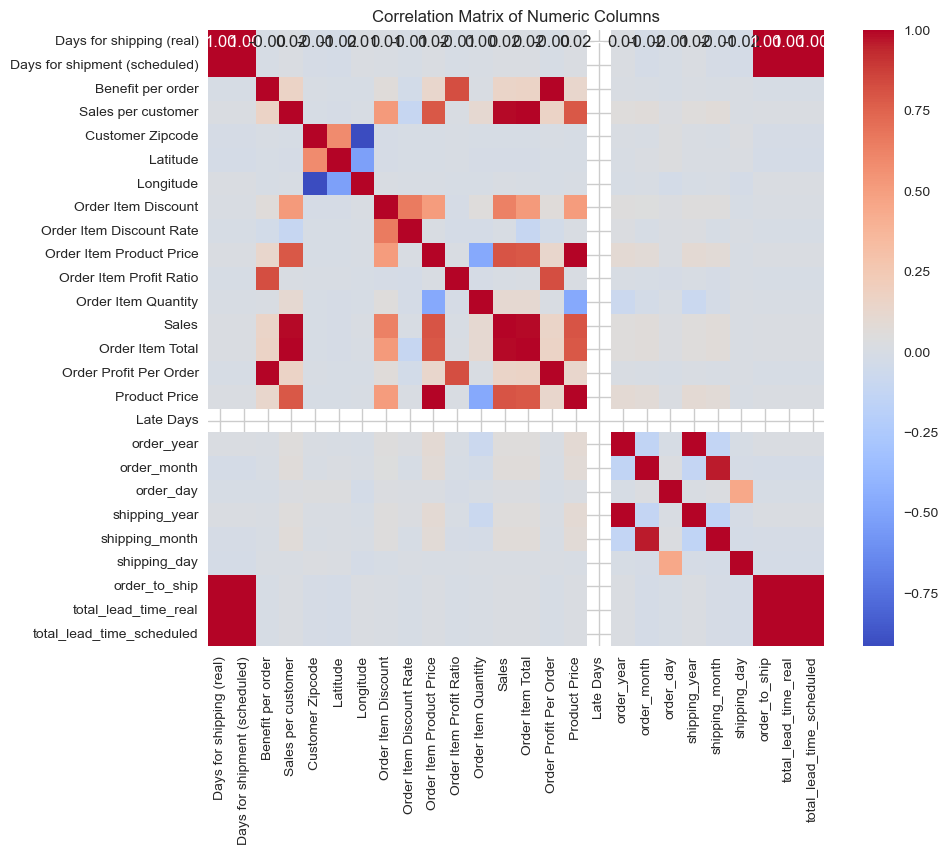

In [75]:
numeric_columns = data.select_dtypes(include=['number'])

# calculate the correlation matrix
corr_matrix = numeric_columns.corr()
corr_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

In [76]:
# Drop columns with high correlation
data = data.drop(columns=['total_lead_time_scheduled', 'total_lead_time_real', 'Benefit per order'])



In [77]:
data = data.drop(['Days for shipping (real)', 'Order Item Product Price', 'Order Item Profit Ratio',
                  'Sales per customer', 'Order Item Total', 'Sales', "Customer Zipcode"], axis=1)

c:\Users\ashwi\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


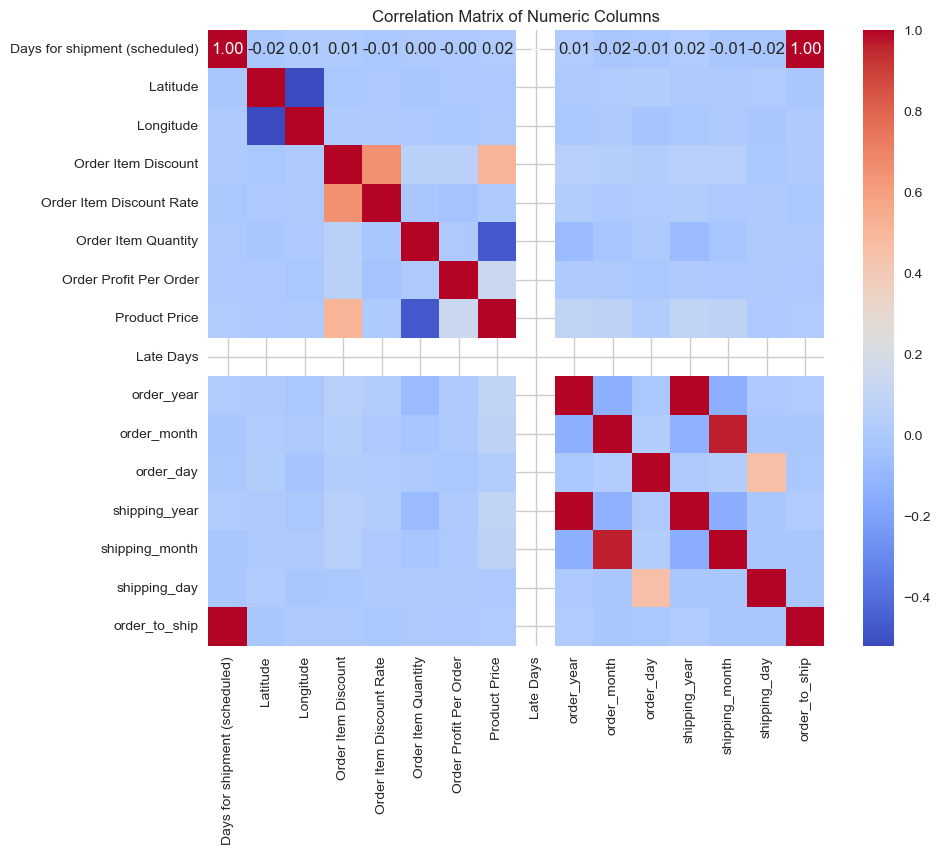

In [78]:
# correlation matrix
numeric_columns = data.select_dtypes(include=['number'])

# calculate the correlation matrix
corr_matrix = numeric_columns.corr()
corr_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

In [79]:
X = data

# define preprocessing steps for numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [80]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# model pipeline
kmeans = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('KMeans', KMeans(n_clusters=8, random_state=10, n_init = 'auto'))
])

kmeans.fit_transform(X)

# retrieve cluster centroids from the KMeans estimator
cluster_centers = kmeans.named_steps['KMeans'].cluster_centers_

# getting feature names after one-hot encoding
one_hot_columns = kmeans.named_steps['preprocessor']\
                            .named_transformers_['cat']\
                            .named_steps['onehot']\
                            .categories_

# combine feature names from numeric and one-hot encoded categorical features
columns = list(numeric_features) + [f"{cat}_{val}" for cat, vals in zip(categorical_features, one_hot_columns) for val in vals]

group = pd.DataFrame(cluster_centers, columns=columns)
print(group)

   Days for shipment (scheduled)  Latitude  Longitude  Order Item Discount  \
0                       0.687398 -1.167463   0.853977            -0.122342   
1                       0.334344  0.705578  -0.563804            -0.237329   
2                      -2.014130  0.758068  -0.527621            -0.126726   
3                       0.565347 -1.159575   0.893455            -0.152214   
4                      -1.265324 -1.155563   0.879643            -0.043995   
5                       0.311586  0.723301  -0.512526            -0.183579   
6                       0.402230  0.712907  -0.575246            -0.188506   
7                       0.263138  0.240603  -0.143944             2.237754   

   Order Item Discount Rate  Order Item Quantity  Order Profit Per Order  \
0                 -0.061496             0.046368                0.006041   
1                 -0.124153             0.132227               -0.042173   
2                 -0.035544            -0.009348               -0.025

In [81]:
cluster_numbers = [2, 3, 4, 5, 6, 7, 8, 9, 10]
inertia_values = []

for n_clusters in cluster_numbers:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('kmeans', KMeans(n_clusters=n_clusters, n_init=10, random_state=10))
    ])

    pipeline.fit(X)

    inertia = pipeline.named_steps['kmeans'].inertia_
    inertia_values.append(inertia)
    print(f"Inertia (WCSS) for {n_clusters} clusters:", inertia)

print("\nInertia values:", inertia_values)

Inertia (WCSS) for 2 clusters: 248753.1145213702
Inertia (WCSS) for 3 clusters: 233369.7418668748
Inertia (WCSS) for 4 clusters: 224067.86038989638
Inertia (WCSS) for 5 clusters: 217306.88028942555
Inertia (WCSS) for 6 clusters: 211510.49116172563
Inertia (WCSS) for 7 clusters: 206208.93758892396
Inertia (WCSS) for 8 clusters: 202365.23444785379
Inertia (WCSS) for 9 clusters: 198459.00629284358
Inertia (WCSS) for 10 clusters: 195759.76728605782

Inertia values: [248753.1145213702, 233369.7418668748, 224067.86038989638, 217306.88028942555, 211510.49116172563, 206208.93758892396, 202365.23444785379, 198459.00629284358, 195759.76728605782]


In [82]:
# retrieve cluster centroids from the KMeans estimator
cluster_centers_scaled = kmeans.named_steps['KMeans'].cluster_centers_

# inverse transform the scaled centroids to get original values for numeric features
scaler = kmeans.named_steps['preprocessor'].named_transformers_['num'].named_steps['scaler']
cluster_centers_numeric = scaler.inverse_transform(cluster_centers_scaled[:, :len(numeric_features)])

# inverse transform the one-hot encoded centroids to get original values for categorical features
onehot = kmeans.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cluster_centers_categorical = onehot.inverse_transform(cluster_centers_scaled[:, len(numeric_features):])

# adjust the code to get the correct number of columns
columns = list(numeric_features) + list(onehot.get_feature_names_out(categorical_features))

# slice the categorical feature names for each category to avoid duplicates
categorical_columns = []
for cat, vals in zip(categorical_features, onehot.categories_):
    categorical_columns.extend([f"{cat}_{val}" for val in vals])

cluster_centers_combined = np.hstack((cluster_centers_numeric, cluster_centers_categorical))

cluster_centers_original = pd.DataFrame(
    data=cluster_centers_numeric,
    columns=numeric_features
)

print(cluster_centers_original)

   Days for shipment (scheduled)   Latitude  Longitude  Order Item Discount  \
0                       4.000000  18.275782 -66.428771            17.886484   
1                       3.477505  36.556788 -96.603716            15.352342   
2                       0.001923  37.069094 -95.833616            17.789865   
3                       3.819374  18.352773 -65.588556            17.228143   
4                       1.110106  18.391932 -65.882515            19.613130   
5                       3.443824  36.729774 -95.512349            16.536909   
6                       3.577971  36.628324 -96.847229            16.428330   
7                       3.372124  32.018603 -87.667742            69.899472   

   Order Item Discount Rate  Order Item Quantity  Order Profit Per Order  \
0                  0.096982             2.197112               24.057545   
1                  0.092597             2.321575               19.176585   
2                  0.098798             2.116346            

In [83]:
print("Shape of cluster_centers_categorical:\n", cluster_centers_categorical)

Shape of cluster_centers_categorical:
 [['DEBIT' 'Cleats' 'Caguas' 'Puerto Rico' 'Consumer' 'PR' 'Fan Shop'
  'LATAM' 'Santo Domingo' 'Estados Unidos' 'Central America' 'California'
  'Standard Class']
 ['DEBIT' "Women's Apparel" 'Brooklyn' 'EE. UU.' 'Consumer' 'CA'
  'Fan Shop' 'Europe' 'Lagos' 'Estados Unidos' 'Western Europe'
  'Inglaterra' 'Standard Class']
 ['DEBIT' "Women's Apparel" 'Chicago' 'EE. UU.' 'Consumer' 'CA'
  'Fan Shop' 'LATAM' 'Lagos' 'Estados Unidos' 'Central America'
  'Inglaterra' 'Same Day']
 ['DEBIT' "Men's Footwear" 'Caguas' 'Puerto Rico' 'Consumer' 'PR'
  'Fan Shop' 'Europe' 'Manila' 'Francia' 'Western Europe' 'Inglaterra'
  'Standard Class']
 ['DEBIT' 'Cleats' 'Caguas' 'Puerto Rico' 'Consumer' 'PR' 'Fan Shop'
  'LATAM' 'New York City' 'Estados Unidos' 'Central America' 'California'
  'Second Class']
 ['DEBIT' "Women's Apparel" 'Brooklyn' 'EE. UU.' 'Consumer' 'CA'
  'Fan Shop' 'LATAM' 'Tegucigalpa' 'Francia' 'Central America'
  'Inglaterra' 'Standard Class']
 [

In [87]:
# Convert it into a dataframe
cluster_centers_categorical_df = pd.DataFrame(cluster_centers_categorical)

cat_dict = {0: 'Type',
            1: 'Category Name',
            2: 'Customer City',
            3: 'Customer Country',
            4: 'Customer Segment',
            5: 'Customer State',
            6: 'Department Name',
            7: 'Markete',
            8: 'Order City',
            9: 'Order Region',
            10: 'Order Country', 
            11: 'Order State',
            12: 'Shipping Mode'}

# Assigning the column names
cluster_centers_categorical_df.columns = [cat_dict[i] for i in range(cluster_centers_categorical_df.shape[1])]

cluster_centers_categorical_df

,Type,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Department Name,Markete,Order City,Order Region,Order Country,Order State,Shipping Mode
0,DEBIT,Cleats,Caguas,Puerto Rico,Consumer,PR,Fan Shop,LATAM,Santo Domingo,Estados Unidos,Central America,California,Standard Class
1,DEBIT,Women's Apparel,Brooklyn,EE. UU.,Consumer,CA,Fan Shop,Europe,Lagos,Estados Unidos,Western Europe,Inglaterra,Standard Class
2,DEBIT,Women's Apparel,Chicago,EE. UU.,Consumer,CA,Fan Shop,LATAM,Lagos,Estados Unidos,Central America,Inglaterra,Same Day
3,DEBIT,Men's Footwear,Caguas,Puerto Rico,Consumer,PR,Fan Shop,Europe,Manila,Francia,Western Europe,Inglaterra,Standard Class
4,DEBIT,Cleats,Caguas,Puerto Rico,Consumer,PR,Fan Shop,LATAM,New York City,Estados Unidos,Central America,California,Second Class
5,DEBIT,Women's Apparel,Brooklyn,EE. UU.,Consumer,CA,Fan Shop,LATAM,Tegucigalpa,Francia,Central America,Inglaterra,Standard Class
6,DEBIT,Cleats,Los Angeles,EE. UU.,Consumer,CA,Fan Shop,LATAM,New York City,Estados Unidos,Central America,California,Standard Class
7,DEBIT,Fishing,Caguas,EE. UU.,Consumer,PR,Fan Shop,Europe,Philadelphia,Estados Unidos,Western Europe,Inglaterra,Standard Class


In [88]:
#  combine the numeric and categorical cluster centers
cluster_centers_combined = pd.concat([cluster_centers_original, cluster_centers_categorical_df], axis=1)

# Floor order_month and shipping_month
cluster_centers_combined['order_month'] = cluster_centers_combined['order_month'].apply(np.floor)
cluster_centers_combined['shipping_month'] = cluster_centers_combined['shipping_month'].apply(np.floor)
# Convert to datetime (month)
cluster_centers_combined['order_month'] = pd.to_datetime(cluster_centers_combined['order_month'], format='%m').dt.month_name().str.slice(stop=3)
cluster_centers_combined['shipping_month'] = pd.to_datetime(cluster_centers_combined['shipping_month'], format='%m').dt.month_name().str.slice(stop=3)

# Floor order_year and shipping_year
cluster_centers_combined['order_year'] = cluster_centers_combined['order_year'].apply(np.floor)
cluster_centers_combined['shipping_year'] = cluster_centers_combined['shipping_year'].apply(np.floor)

# Convert to datetime (year)
cluster_centers_combined['order_year'] = pd.to_datetime(cluster_centers_combined['order_year'], format='%Y').dt.year
cluster_centers_combined['shipping_year'] = pd.to_datetime(cluster_centers_combined['shipping_year'], format='%Y').dt.year


# covert features to datetime
cluster_centers_combined

,Days for shipment (scheduled),Latitude,Longitude,Order Item Discount,Order Item Discount Rate,Order Item Quantity,Order Profit Per Order,Product Price,Late Days,order_year,order_month,order_day,shipping_year,shipping_month,shipping_day,order_to_ship,Type,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Department Name,Markete,Order City,Order Region,Order Country,Order State,Shipping Mode
0,4.000000,18.275782,-66.428771,17.886484,0.096982,2.197112,24.057545,125.593534,0.0,2016,Mar,15.318412,2016,Mar,16.010108,4.000000,DEBIT,Cleats,Caguas,Puerto Rico,Consumer,PR,Fan Shop,LATAM,Santo Domingo,Estados Unidos,Central America,California,Standard Class
1,3.477505,36.556788,-96.603716,15.352342,0.092597,2.321575,19.176585,106.704491,0.0,2015,Sep,17.099182,2015,Sep,16.288344,3.477505,DEBIT,Women's Apparel,Brooklyn,EE. UU.,Consumer,CA,Fan Shop,Europe,Lagos,Estados Unidos,Western Europe,Inglaterra,Standard Class
2,0.001923,37.069094,-95.833616,17.789865,0.098798,2.116346,20.825587,122.140224,0.0,2015,Jun,16.013462,2015,Jun,16.015385,0.001923,DEBIT,Women's Apparel,Chicago,EE. UU.,Consumer,CA,Fan Shop,LATAM,Lagos,Estados Unidos,Central America,Inglaterra,Same Day
3,3.819374,18.352773,-65.588556,17.228143,0.095055,2.195193,20.625907,126.789726,0.0,2015,Sep,15.433358,2015,Sep,14.582666,3.819374,DEBIT,Men's Footwear,Caguas,Puerto Rico,Consumer,PR,Fan Shop,Europe,Manila,Francia,Western Europe,Inglaterra,Standard Class
4,1.110106,18.391932,-65.882515,19.613130,0.102715,2.202866,23.698522,127.568057,0.0,2015,May,16.032428,2015,May,16.275264,1.110106,DEBIT,Cleats,Caguas,Puerto Rico,Consumer,PR,Fan Shop,LATAM,New York City,Estados Unidos,Central America,California,Second Class
5,3.443824,36.729774,-95.512349,16.536909,0.094035,2.024209,26.674531,131.937433,0.0,2017,May,16.205462,2017,May,15.333333,3.443824,DEBIT,Women's Apparel,Brooklyn,EE. UU.,Consumer,CA,Fan Shop,LATAM,Tegucigalpa,Francia,Central America,Inglaterra,Standard Class
6,3.577971,36.628324,-96.847229,16.428330,0.095316,2.297391,20.881942,114.575748,0.0,2015,Mar,15.816812,2015,Mar,16.387246,3.577971,DEBIT,Cleats,Los Angeles,EE. UU.,Consumer,CA,Fan Shop,LATAM,New York City,Estados Unidos,Central America,California,Standard Class
7,3.372124,32.018603,-87.667742,69.899472,0.174601,1.102842,41.021286,415.401200,0.0,2016,Jul,17.009472,2016,Jul,16.009472,3.372124,DEBIT,Fishing,Caguas,EE. UU.,Consumer,PR,Fan Shop,Europe,Philadelphia,Estados Unidos,Western Europe,Inglaterra,Standard Class


In [89]:
cluster_centers_combined

,Days for shipment (scheduled),Latitude,Longitude,Order Item Discount,Order Item Discount Rate,Order Item Quantity,Order Profit Per Order,Product Price,Late Days,order_year,order_month,order_day,shipping_year,shipping_month,shipping_day,order_to_ship,Type,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Department Name,Markete,Order City,Order Region,Order Country,Order State,Shipping Mode
0,4.000000,18.275782,-66.428771,17.886484,0.096982,2.197112,24.057545,125.593534,0.0,2016,Mar,15.318412,2016,Mar,16.010108,4.000000,DEBIT,Cleats,Caguas,Puerto Rico,Consumer,PR,Fan Shop,LATAM,Santo Domingo,Estados Unidos,Central America,California,Standard Class
1,3.477505,36.556788,-96.603716,15.352342,0.092597,2.321575,19.176585,106.704491,0.0,2015,Sep,17.099182,2015,Sep,16.288344,3.477505,DEBIT,Women's Apparel,Brooklyn,EE. UU.,Consumer,CA,Fan Shop,Europe,Lagos,Estados Unidos,Western Europe,Inglaterra,Standard Class
2,0.001923,37.069094,-95.833616,17.789865,0.098798,2.116346,20.825587,122.140224,0.0,2015,Jun,16.013462,2015,Jun,16.015385,0.001923,DEBIT,Women's Apparel,Chicago,EE. UU.,Consumer,CA,Fan Shop,LATAM,Lagos,Estados Unidos,Central America,Inglaterra,Same Day
3,3.819374,18.352773,-65.588556,17.228143,0.095055,2.195193,20.625907,126.789726,0.0,2015,Sep,15.433358,2015,Sep,14.582666,3.819374,DEBIT,Men's Footwear,Caguas,Puerto Rico,Consumer,PR,Fan Shop,Europe,Manila,Francia,Western Europe,Inglaterra,Standard Class
4,1.110106,18.391932,-65.882515,19.613130,0.102715,2.202866,23.698522,127.568057,0.0,2015,May,16.032428,2015,May,16.275264,1.110106,DEBIT,Cleats,Caguas,Puerto Rico,Consumer,PR,Fan Shop,LATAM,New York City,Estados Unidos,Central America,California,Second Class
5,3.443824,36.729774,-95.512349,16.536909,0.094035,2.024209,26.674531,131.937433,0.0,2017,May,16.205462,2017,May,15.333333,3.443824,DEBIT,Women's Apparel,Brooklyn,EE. UU.,Consumer,CA,Fan Shop,LATAM,Tegucigalpa,Francia,Central America,Inglaterra,Standard Class
6,3.577971,36.628324,-96.847229,16.428330,0.095316,2.297391,20.881942,114.575748,0.0,2015,Mar,15.816812,2015,Mar,16.387246,3.577971,DEBIT,Cleats,Los Angeles,EE. UU.,Consumer,CA,Fan Shop,LATAM,New York City,Estados Unidos,Central America,California,Standard Class
7,3.372124,32.018603,-87.667742,69.899472,0.174601,1.102842,41.021286,415.401200,0.0,2016,Jul,17.009472,2016,Jul,16.009472,3.372124,DEBIT,Fishing,Caguas,EE. UU.,Consumer,PR,Fan Shop,Europe,Philadelphia,Estados Unidos,Western Europe,Inglaterra,Standard Class
